<a href="https://colab.research.google.com/github/EmAchieng/DataSciencePracticeSeries/blob/master/AppliedML_California_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id='Q0'></a>
<center><a target="_blank" href="http://www.propulsion.academy"><img src="https://drive.google.com/uc?id=1McNxpNrSwfqu1w-QtlOmPSmfULvkkMQV" width="200" style="background:none; border:none; box-shadow:none;" /></a> </center>
<center> <h4 style="color:#303030"> Applied Machine Learning: </h4> </center>
<center> <h1 style="color:#303030">Predict House Value using neighboorhood characteristics</h1> </center>
<p style="margin-bottom:1cm;"></p>
<center style="color:#303030"><h4>Propulsion Academy, 2021</h4></center>
<p style="margin-bottom:1cm;"></p>

<div style="background:#EEEDF5;border-top:0.1cm solid #EF475B;border-bottom:0.1cm solid #EF475B;">
    <div style="margin-left: 0.5cm;margin-top: 0.5cm;margin-bottom: 0.5cm">
        <p><strong>Goal:</strong>Practice working on a Regression problem using real estate data</p>
        <strong> Sections:</strong>
        <a id="P0" name="P0"></a>
        <ol>
            <li> <a style="color:#303030" href="#SU">Set Up </a> </li>
            <li> <a style="color:#303030" href="#P1">Exploratory Data Analysis</a></li>
            <li> <a style="color:#303030" href="#P2">Modeling</a></li>
            <li> <a style="color:#303030" href="#P3">Model Evaluation and Explanation</a></li>
        </ol>
        <strong>Topics Trained:</strong> Clustering.
    </div>
</div>

<nav style="text-align:right"><strong>
        <a style="color:#00BAE5" href="https://monolith.propulsion-home.ch/backend/api/momentum/materials/hsg-materials/index.html" title="momentum"> HSG Python for Data Science</a>|
        <a style="color:#00BAE5" href="https://monolith.propulsion-home.ch/backend/api/momentum/materials/hsg-materials/chapters/homework/index.html" title="momentum">Applied Machine Learning</a>|
        <a style="color:#00BAE5" href="https://colab.research.google.com/drive/1zjDdhyfS11YaGWV2rQvioyuqZcmkUC9V?usp=sharing" title="momentum">  California House Dataset</a>
</strong></nav>

This Tutorial walks you through a complete Regression Project, including: Exploratory data analysis, Feature Engineering, Defining a baseline model, finding a more performant model using automated machine learning, evaluating the final model using your test set, and finally explaining your model's prediction using shapley values.

<a id='SU' name="SU"></a>
## [Set up](#P0)

### package install

Let's start with auto-sklearn, our library for automated machine learning.

Please note you **need to restart the run after the installation** for it to take effect!

In [ ]:
!sudo apt-get install build-essential swig
!curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install
!pip install auto-sklearn

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 31 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 1s (791 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 2.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (Thi

In [ ]:
!pip install pipelineprofiler # visualize the pipelines created by auto-sklearn

In [ ]:
!pip install shap

In [ ]:
!pip install --upgrade plotly

In [ ]:
!pip3 install -U scikit-learn

### Packages imports

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import set_config
from sklearn.pipeline import Pipeline
from pandas_profiling import ProfileReport
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin

import plotly.express as px
import plotly.graph_objects as go

In [ ]:
import autosklearn.regression
import PipelineProfiler

In [ ]:
import shap

### Google Drive connection

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

### options and settings

In [ ]:
data_path = "/content/drive/MyDrive/Introduction2DataScience/data/"

In [ ]:
set_config(display='diagram')

Please Download the data from [this source](https://drive.google.com/file/d/1MUZrfW214Pv9p5cNjNNEEosiruIlLUXz/view?usp=sharing), and upload it on your Introduction2DataScience/data google drive folder.

<a id='P1' name="P1"></a>
## [Exploratory Data Analysis](#P0)


### Understand the Context

**What type of problem are we trying to solve?**

With this data set, we want to build a model that would predict the price of a house from its characteristics. 

**_This is a regression problem_**

**How was the data collected?/ Is there documentation on the Data?**

California Housing dataset [description](https://www.kaggle.com/camnugent/california-housing-prices): 

**Context**:

The data contains information from the 1990 California census. 
So although it may not help you with predicting current housing prices, it does provide an accessible introductory dataset for teaching people about the basics of machine learning.

**Content**:  

The data pertains to the houses found in a given California district and some summary stats about them based on the 1990 census data. Be warned the data aren't cleaned so there are some preprocessing steps required! The columns are as follows, their names are pretty self explanatory:

  - longitude: A measure of how far west a house is; a higher value is farther west

  - latitude: A measure of how far north a house is; a higher value is farther north

  - housing_median_age: Median age of a house within a block; a lower number is a newer building

  - total_rooms: Total number of rooms within a block

  - total_bedrooms:  Total number of bedrooms within a block

  - population: Total number of people residing within a block

  - households:  Total number of households, a group of people residing within a home unit, for a block

  - median_income: Median income for households within a block of houses (measured in tens of thousands of US Dollars)

  - median_house_value: (response)   Median house value for households within a block (measured in US Dollars)

**Do we have assumption about the data?**

- longitude and lattitude should be numbers corresponding to the longitude and latitude of California [36.7783° N, 119.4179° W](https://www.google.com/search?q=longitude%2Flatitude+of+california&oq=longitude%2Flatitude+of+california&aqs=chrome..69i57j0i22i30l6j69i58.9953j0j7&sourceid=chrome&ie=UTF-8)!
- housing_median_age should be of [the order of 40-70](https://www.bestplaces.net/housing/city/california/los_angeles)
- we should see higher prices around big cities like Loas Angeles/San Francisco

**Can we foresee any challenge related to this data set?**

We have geographical data, which calls for specific visualization techniques at least.

the features total_rooms and total bedrooms might need to be modified to more meaning ful values like number of bedrooms per household/per person

### Data Structure and types

**Load the csv file as a DataFrame using Pandas**

In [ ]:
df = pd.read_csv(f'{data_path}california_housing.csv')

**How many columns and rows do we have?**

In [ ]:
df.shape

**What are the names and meaning of each columns?**

In [ ]:
df.columns

print the first 10 rows of the dataframe

In [ ]:
df.head()

**What are the types of each column?**

In [ ]:
df.dtypes

It's all floating point numbers, that all makes sense!!

**Do the types correspond to what you expected?
if not, which columns would you change and why?**

some columns are actually integers, but we can keep it this way

**Perform the necessary type transformations**

nothing to do here

**What are the possible categories for categorical columns?/What is the min, max and mean of each numerical columns?**

In [ ]:
df.describe(include='all',datetime_is_numeric=True)

**Perform test/train split here**

!!! Please think about it!!! How should the data be splitted?

In [ ]:
train, test = train_test_split(df, test_size=0.2, random_state=0)

In [ ]:
train.to_csv(f'{data_path}CaliforniaTrain.csv', index=False)

In [ ]:
train= train.copy()

In [ ]:
test.to_csv(f'{data_path}CaliforniaTest.csv', index=False)

In [ ]:
test = test.copy()

### Missing Values and Duplicates

**Are there some duplicate columns? rows?**

Let's print again the columns:

In [ ]:
train.columns

and the first rows:

In [ ]:
train.head()

Every column has a specific meaning, there are no duplicate columns.

Let's check for duplicate rows:

In [ ]:
train.duplicated(keep=False).value_counts()

There are no duplicate rows.

**Should we drop duplicate rows?**

does not apply

**How many missing values are there in each columns?**

to answer this question, we can use the count method, which counts the number of rows that have a value (the non-missing data!): 

In [ ]:
print((train.shape[0] - train.count()).to_string())

There are missing values in the total_bedroom column. Let's check if there is something specific about these rows:

In [ ]:
train[train['total_bedrooms'].isna()]

We can't see much of a pattern. Let's look at the distribution of the data before we decide on an imputer!

### Data Distribution and Outliers

**What is the distribution of numerical/categorical data?**

Let's plot histograms of all the columns:

In [ ]:
for column in train:
    fig = px.histogram(train, x=column)
    fig.update_layout(width=700, height=300)
    fig.show()

The following columns have a high frequency in their max values:

- ``housing_median_age``
- ``median_income``
- ``median_house_value``

It looks like the actual values haven't been collected beyond a certain threshold.

It's difficult to really visualize the data without a map. plotly express proposes several options for [maps](https://plotly.com/python/maps/). Let's have a closer look at the geographical distribution of our dataset:

In [ ]:
fig = px.scatter_mapbox(train, lat="latitude", lon='longitude', color="median_house_value", size="population",
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=5,
                    mapbox_style="carto-positron", hover_data = ['households', 'median_income'])
fig.update_layout(width=1000, height=1000)
fig.show()

The data set is indeed mapping into California, and both the broad patterns of population size and house  median Price make sense: like we expected, the population is high in big cities, and the houses are more expensive on the coast around big cities.

**Are there clear outliers?**

We saw that some variables had very high frequencies in their max values, suggesting the data has been somehow cutoff. let's investigate these rows, to check if there are some obvious patterns:

In [ ]:
train[train['median_house_value'] == 500001]

there are no obvious trends.. let's have a look at the statistics of this matrix:

In [ ]:
train[train['median_house_value'] == 500001].describe(include='all',datetime_is_numeric=True)

In [ ]:
train[(train['housing_median_age'] == 52)]

In [ ]:
train[(train['housing_median_age'] == 52)].describe(include='all',datetime_is_numeric=True)

In [ ]:
train[(train['median_income'] == 15.0001)]

In [ ]:
train[(train['median_income'] == 15.0001)].describe(include='all',datetime_is_numeric=True)

**Can we rule out some outliers as mistakes in the data collecting process?**

no.

**How should we deal with outliers?**

If we use a linear model, we should get rid of these max values, as they will bias the model.

### Relationship between features (correlations)

**What are the relationships between features (make a pairplot)? Are they linear?**

In [ ]:
train.corr().style.background_gradient(cmap='coolwarm')

Here is what we see:

- The features 'total_rooms', 'total_bedrooms', 'population', 'households' are highly correlated with each other.
- 'latitude' and 'longitude' also have a high correlation coefficient.
- finally, the 'median_income' is highly correlated with the 'median_house_value'


In [ ]:
fig = px.scatter_matrix(train[['latitude','housing_median_age', 'total_rooms', 'median_income', 'median_house_value']])
fig.show()

The relationships of features to the median house value seem far from linear!

**What correlation coefficients should be computed?**

Standard Pearson Correlation Coefficients are fine!

**Is there risk of data leakage?**

it does not appear to be the case here

### Feature Creation and Combination



- **What kind of Scaling should we use/try?**
- **Should we transform some features?**
- **Should we drop some features?**
- **Should we combine features?**

In the preceding section, we saw that the features 'total_rooms', 'total_bedrooms', 'population', 'households' are highly correlated with each other.


Let's have a look at how we could create more independant and meaningful features. For example we could have a look at the ratio between the total number of bedrooms and the total number of rooms. Likewise, we could compute the number of rooms per household and the number of people per household:


In [ ]:
new_train = train.copy()

In [ ]:
new_train['bedroom_per_room'] = new_train['total_bedrooms']/new_train['total_rooms']
new_train['rooms_per_household'] = new_train['total_rooms']/new_train['households']
new_train['population_per_household'] = new_train['population']/new_train['households']

finally, let's get rid of "outliers": the maximum values of columns median_income, housing_median_age, and median_house_value: 

In [ ]:
new_train = new_train[~(new_train['median_income'] == 15.0001)]
new_train = new_train[~(new_train['housing_median_age'] == 52)]
new_train = new_train[~(new_train['median_house_value'] == 500001)]

In [ ]:
new_train.columns

In [ ]:
new_train = new_train[['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income', 'bedroom_per_room', 'rooms_per_household',
       'population_per_household', 'median_house_value']]

With these transformations, let's plot the correlation matrix again:

In [ ]:
new_train.corr().style.background_gradient(cmap='coolwarm')

**_What do you observe?_**

Let's compare this correlation matrix with the correlation matrix we had last section:

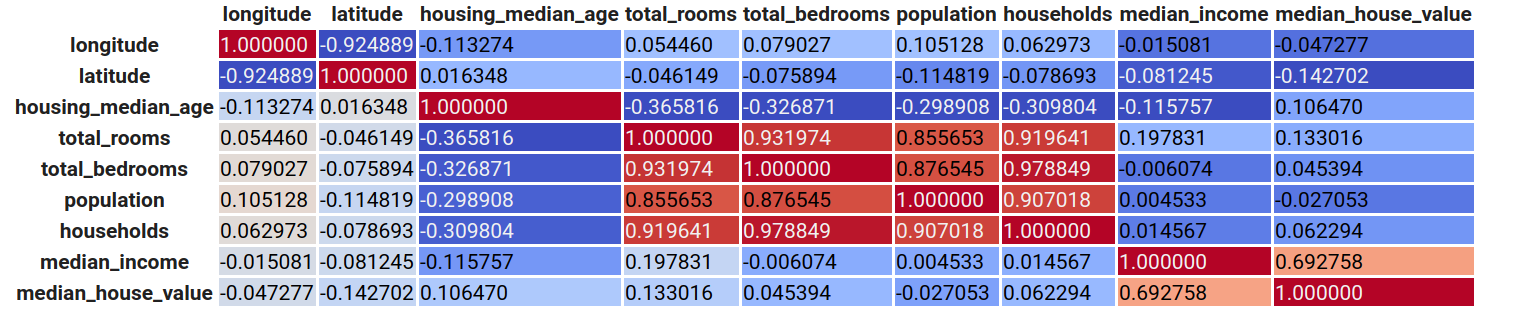

we have lower correlations between features with our feature transformations, and higher correlation with the target.

For all the features that were not changed, we can see the correlations dropped due to getting rid of extreme valuesfor columns median_income, housing_median_age, and median_house_value

### Conclusion: Experimental setup and  Possible Feature Transformations

Let's wrap up on the exploratory data analysis and conclude. We should now be able to answer the following questions:

- **What would be our baseline for the analysis?**
- **What kind of modelling setup should we use/try?**
- **What kind of Scaling should we use/try?**
- **If outliers, what kind of treatment should we apply?**
- **Should we transform some features?**
- **Should we drop some features?**
- **Should we combine features?**

In our baseline analysis, we could do a linear regression using the features created in the Feature Creation and Combination section, without the outliers.

We should scale our features using a standard scaler and 

Finally, we could use a median imputer to fill NaN values in the total_bedroom column.

At this stage, we can keep all the features we have.

<a id='P2' name="P2"></a>
## [Modelling](#P0)

In [ ]:
X_train, y_train = train.iloc[:,:-1], train.iloc[:,-1] 

In [ ]:
train_no_out = train.copy()
train_no_out = train_no_out[~(train_no_out['median_income'] == 15.0001)]
train_no_out = train_no_out[~(train_no_out['housing_median_age'] == 52)]
train_no_out = train_no_out[~(train_no_out['median_house_value'] == 500001)]
X_train_no_out, y_train_no_out = train_no_out.iloc[:,:-1], train_no_out.iloc[:,-1] 

### Base Model

#### Pipeline definition

In [ ]:
X_train.columns

In [ ]:
class FeaturesAdder(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        bedrooms_per_rooms = X[:, 4] / X[:, 3]
        rooms_per_household = X[:, 3] / X[:, 6]
        population_per_household = X[:, 5] / X[:, 6]
        return np.c_[X, bedrooms_per_rooms, rooms_per_household, population_per_household]

feature_adder = FeaturesAdder()

In [ ]:
scaler = StandardScaler()
imputer = SimpleImputer(strategy='median')
regr = LinearRegression()
model = Pipeline(steps=[('imputer', imputer),
                        ('features', feature_adder), 
                        ('scaler', scaler),
                        ('regressor', regr)])

In [ ]:
model2 = Pipeline(steps=[('imputer', imputer),
                        ('features', feature_adder), 
                         ('scaler', scaler),
                        ('regressor', regr)])

#### Model cross validation

In [ ]:
cross_val_score(model, X_train, y_train)

In [ ]:
cross_val_score(model2, X_train_no_out, y_train_no_out )

### Automl

In [ ]:
automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=600,
    per_run_time_limit=30,
)
automl.fit(X_train, y_train)

In [ ]:
profiler_data= PipelineProfiler.import_autosklearn(automl)
PipelineProfiler.plot_pipeline_matrix(profiler_data)

<a id='P2' name="P2"></a>
## [Model Evluation and Explainability](#P0)

Let's separate our test dataframe into a feature variable (X_test), and a target variable (y_test):

In [ ]:
X_test, y_test = test.iloc[:,:-1], test.iloc[:,-1]

#### Model Evaluation

Now, we can attempt to predict the median house value from our test set. To do that, we just use the .predict method on the object "automl" that we created and trained in the last sections:

In [ ]:
y_pred = automl.predict(X_test)

In [ ]:
y_pred

Let's now evaluate it using the mean_squared_error function from scikit learn:

In [ ]:
mean_squared_error(y_test, y_pred)

and the $R^2$ score:

In [ ]:
automl.score(X_test, y_test)

we can also plot the y_test vs y_pred scatter:

In [ ]:
df = pd.DataFrame(np.concatenate((X_test, y_test.to_numpy().reshape(-1,1), y_pred.reshape(-1,1)),  axis=1))

In [ ]:
df

In [ ]:
df.columns = ['longitude', 'latitude', 'housing_median_age', 'households',
               'median_income', 'bedroom_per_room',
               'rooms_per_household', 'population_per_household', 'True Target', 'Predicted Target']

In [ ]:
column = 'median_income'
sorted_df = df.sort_values(by=column)
fig = px.scatter(df, x=column, y='True Target')
fig.add_trace(go.Scatter(x=df[column], y=df['Predicted Target'],
                    mode='markers',
                    name='model'))
fig.show()

In [ ]:
fig = px.scatter(df, x='Predicted Target', y='True Target')
fig.show()

#### Model Explainability

In [ ]:
explainer = shap.KernelExplainer(model = automl.predict, data = X_test.iloc[:50, :], link = "identity")


In [ ]:
# Set the index of the specific example to explain
X_idx = 0
shap_value_single = explainer.shap_values(X = X_test.iloc[X_idx:X_idx+1,:], nsamples = 100)
X_test.iloc[X_idx:X_idx+1,:]
# print the JS visualization code to the notebook
shap.initjs()
shap.force_plot(base_value = explainer.expected_value,
                shap_values = shap_value_single,
                features = X_test.iloc[X_idx:X_idx+1,:]
                )

In [ ]:
shap_values = explainer.shap_values(X = X_test.iloc[0:50,:], nsamples = 100)

In [ ]:
# print the JS visualization code to the notebook
shap.initjs()
shap.summary_plot(shap_values = shap_values,
                  features = X_test.iloc[0:50,:]
                  )